In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download ASL dataset directly using the Kaggle API
!kaggle datasets download -d grassknoted/asl-alphabet

# Extract dataset
!unzip -q asl-alphabet.zip -d asl_dataset


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0


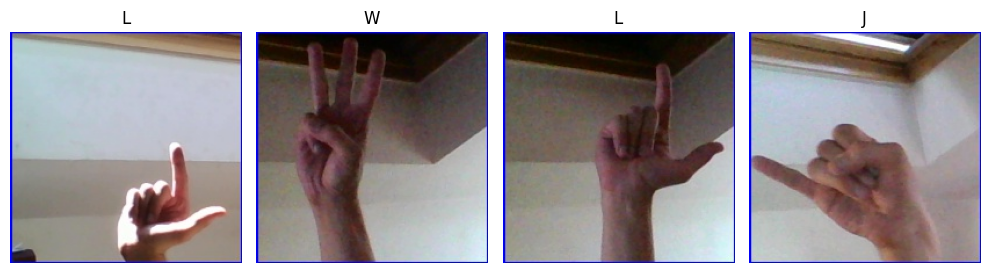

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to dataset
dataset_path = '/content/asl_dataset/asl_alphabet_train/asl_alphabet_train'

# Get all class folders
all_classes = os.listdir(dataset_path)

# Pick 4 random images
image_paths = []
for _ in range(4):
    cls = random.choice(all_classes)
    cls_path = os.path.join(dataset_path, cls)
    img_file = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_file)
    image_paths.append((img_path, cls))

# Plot
plt.figure(figsize=(10, 5))
for i, (path, label) in enumerate(image_paths):
    img = mpimg.imread(path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Set paths
original_dataset = "/content/asl_dataset/asl_alphabet_train/asl_alphabet_train"
target_base = "/content/asl_split"
train_dir = os.path.join(target_base, "train")

# Config
images_per_class = 1000
train_count = 1000

# Create target dirs
os.makedirs(train_dir, exist_ok=True)

# Go through each class folder
for label in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, label)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    selected = random.sample(images, images_per_class)

    # Prepare class dirs
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)

    # Copy train images
    for img_name in tqdm(selected[:train_count], desc=f"Train - {label}"):
        src = os.path.join(class_path, img_name)
        dst = os.path.join(train_dir, label, img_name)
        shutil.copy(src, dst)



print(" Done: 1000 images/class")


Train - B: 100%|██████████| 1000/1000 [00:00<00:00, 6418.18it/s]

 Done: 1000 images/class


In [ ]:
import mediapipe as mp
import cv2
import os
import shutil
import pandas as pd
from tqdm import tqdm
import random

# Paths
dataset_path = "/content/asl_split/train"
output_csv = "asl_keypoints_dataset_1000.csv"

# MediaPipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Store keypoints data
data = []

# Iterate over classes (folders)
for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    selected_images = random.sample(images, 1000)

    # Process each selected image
    for image_name in tqdm(selected_images, desc=f"Processing {label}"):
        img_path = os.path.join(class_dir, image_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Convert to RGB and process with MediaPipe
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            # Extract keypoints for the first hand
            hand = results.multi_hand_landmarks[0]
            keypoints = []
            for lm in hand.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])  # 21 keypoints * 3 (x, y, z)

            # Add label and keypoints data
            keypoints.append(label)  # Add label as last column
            data.append(keypoints)

# Define columns: 63 keypoints (21x3) + 1 label column
columns = [f"{coord}{i}" for i in range(21) for coord in ['x', 'y', 'z']] + ['label']

# Save the data to CSV
df = pd.DataFrame(data, columns=columns)
df.to_csv(output_csv, index=False)

print(f"Keypoints extraction complete. Data saved to {output_csv}.")


Processing B: 100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


Keypoints extraction complete. Data saved to asl_keypoints_dataset_1000.csv.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/asl_keypoints_dataset_1000.csv")
df.head()

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,x18,y18,z18,x19,y19,z19,x20,y20,z20,label
0,0.402012,0.656884,0.000001,0.465640,0.616356,-0.056257,0.484168,0.527197,-0.069608,0.402680,...,0.314174,0.436343,-0.102341,0.336320,0.476447,-0.116951,0.353296,0.520567,-0.119848,W
1,0.349342,0.661265,0.000001,0.400994,0.613296,-0.063155,0.417196,0.524337,-0.077703,0.335281,...,0.258071,0.421255,-0.095625,0.274486,0.463116,-0.107898,0.286152,0.509333,-0.107912,W
2,0.462711,0.684523,0.000001,0.530809,0.641010,-0.058335,0.558071,0.553550,-0.079387,0.484528,...,0.387456,0.387494,-0.092521,0.405373,0.427159,-0.096203,0.418346,0.473558,-0.091900,W
3,0.373666,0.858605,0.000002,0.486683,0.812843,-0.077447,0.532139,0.699374,-0.105152,0.424602,...,0.259655,0.587609,-0.200558,0.306061,0.645164,-0.244569,0.334715,0.701227,-0.264660,W
4,0.475729,0.863822,0.000001,0.541609,0.834530,-0.049215,0.572869,0.763643,-0.067303,0.507250,...,0.388839,0.687394,-0.110434,0.420346,0.715853,-0.128073,0.444829,0.750367,-0.133706,W


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load your CSV file
df = pd.read_csv("/content/asl_keypoints_dataset_1000.csv")

# Let's visualize the x, y, z coordinates for a few samples (e.g., 'A')
sample_data = df[df['label'] == 'A'].iloc[0]  # First sample of class 'A'

# Extract the x, y, z values for the 21 keypoints
keypoints_x = [sample_data[f'x{i}'] for i in range(21)]
keypoints_y = [sample_data[f'y{i}'] for i in range(21)]
keypoints_z = [sample_data[f'z{i}'] for i in range(21)]

# Create 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=keypoints_x,
    y=keypoints_y,
    z=keypoints_z,
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8)
)])

# Set labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X coordinates',
        yaxis_title='Y coordinates',
        zaxis_title='Z coordinates',
    ),
    title='3D Visualization of Hand Keypoints for Sign A'
)

# Show plot
fig.show()


Neural Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Load the CSV data
df = pd.read_csv('/content/asl_keypoints_dataset_1000.csv')

# Separate features and labels
X = df.drop(columns='label').values  # Keypoints (x, y, z)
y = df['label'].values  # Gesture labels

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_onehot = to_categorical(y_encoded)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Build the Neural Network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer 1
model.add(Dense(32, activation='relu'))  # Hidden layer 2
model.add(Dense(y_onehot.shape[1], activation='softmax'))  # Output layer (softmax for multi-class classification)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Accuracy Score
print(f"Accuracy Score: {accuracy_score(y_test_classes, y_pred_classes) * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1604 - loss: 2.9429 - val_accuracy: 0.5780 - val_loss: 1.3272
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 1.1265 - val_accuracy: 0.7800 - val_loss: 0.7436
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8177 - loss: 0.6720 - val_accuracy: 0.8360 - val_loss: 0.5762
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8667 - loss: 0.5100 - val_accuracy: 0.8770 - val_loss: 0.4830
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8905 - loss: 0.4174 - val_accuracy: 0.9068 - val_loss: 0.3834
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9037 - loss: 0.3540 - val_accuracy: 0.9195 - val_loss: 0.3341
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9209 - loss: 0.3030 - val_accuracy: 0.9242 - val_loss: 0.3015
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9355 - loss: 0.2691 - val_accuracy: 0.

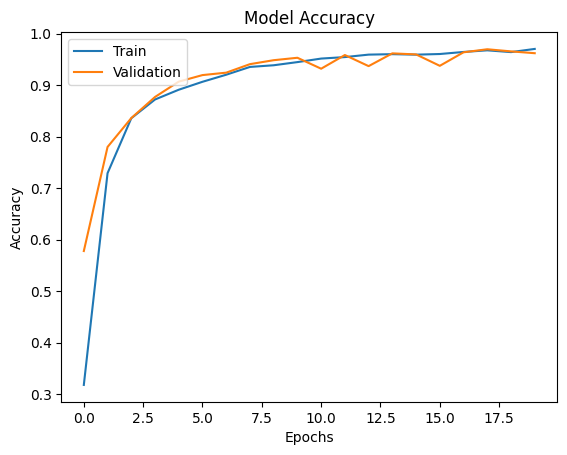

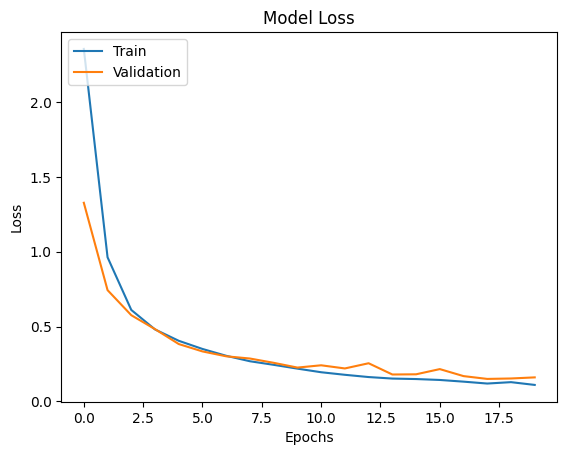

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# Load the CSV data
df = pd.read_csv('/content/asl_keypoints_dataset_1000.csv')

# Separate features and labels
X = df.drop(columns='label').values  # Keypoints (x, y, z)
y = df['label'].values  # Gesture labels

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy Score
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       151
           1       0.99      0.99      0.99       158
           2       0.98      0.99      0.99       130
           3       0.98      0.94      0.96       174
           4       0.93      0.99      0.96       153
           5       0.99      0.99      0.99       201
           6       0.96      0.99      0.98       138
           7       1.00      0.96      0.98       164
           8       1.00      0.97      0.98       147
           9       1.00      0.97      0.99       150
          10       0.96      0.98      0.97       176
          11       0.98      1.00      0.99       170
          12       0.86      0.96      0.90       112
          13       0.97      0.87      0.92        86
          14       0.96      0.98      0.97       163
          15       0.95      0.96      0.96       135
          16       0.99      0.96      0.97       134
    

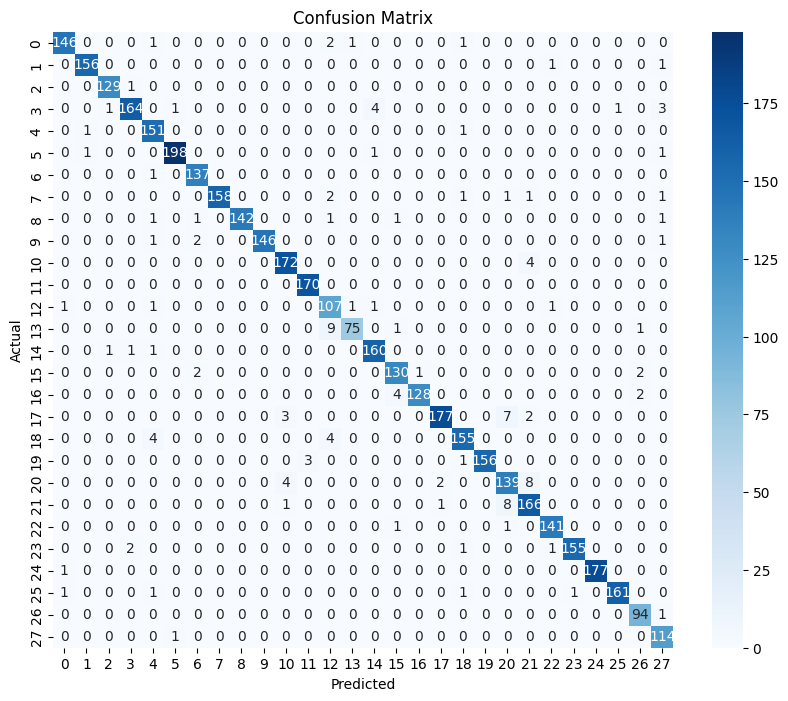

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Gradient Boosting Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# Load the CSV data
df = pd.read_csv('/content/asl_keypoints_dataset_1000.csv')

# Separate features and labels
X = df.drop(columns='label').values  # Keypoints (x, y, z)
y = df['label'].values  # Gesture labels

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = gb_model.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy Score
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       151
           1       0.98      0.99      0.98       158
           2       0.98      1.00      0.99       130
           3       0.98      0.94      0.96       174
           4       0.96      0.95      0.95       153
           5       1.00      0.97      0.98       201
           6       0.98      1.00      0.99       138
           7       1.00      0.96      0.98       164
           8       0.97      0.97      0.97       147
           9       0.99      0.96      0.97       150
          10       0.97      0.95      0.96       176
          11       0.99      0.99      0.99       170
          12       0.77      0.92      0.84       112
          13       0.87      0.77      0.81        86
          14       0.96      0.96      0.96       163
          15       0.91      0.96      0.93       135
          16       0.96      0.89      0.92       134
    

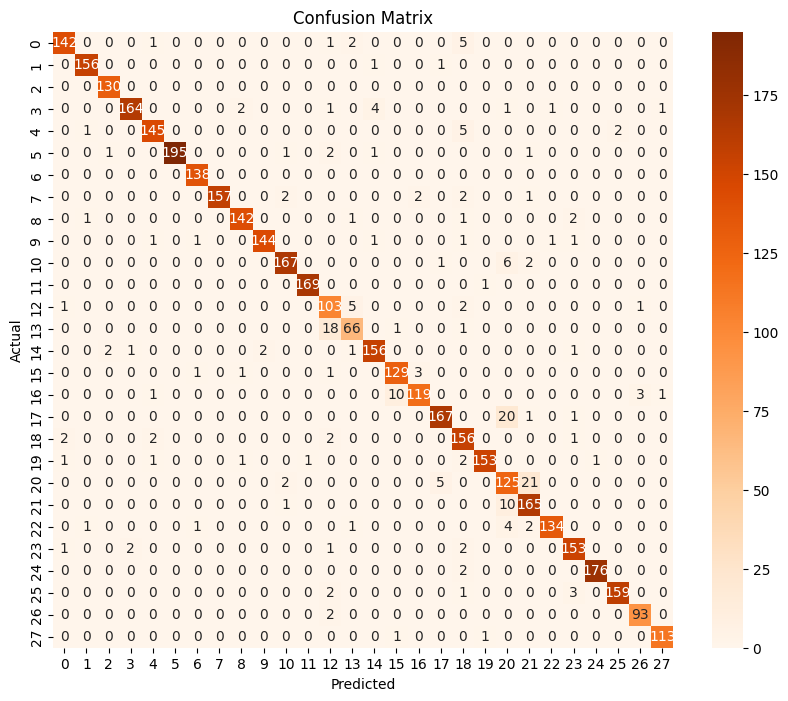

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


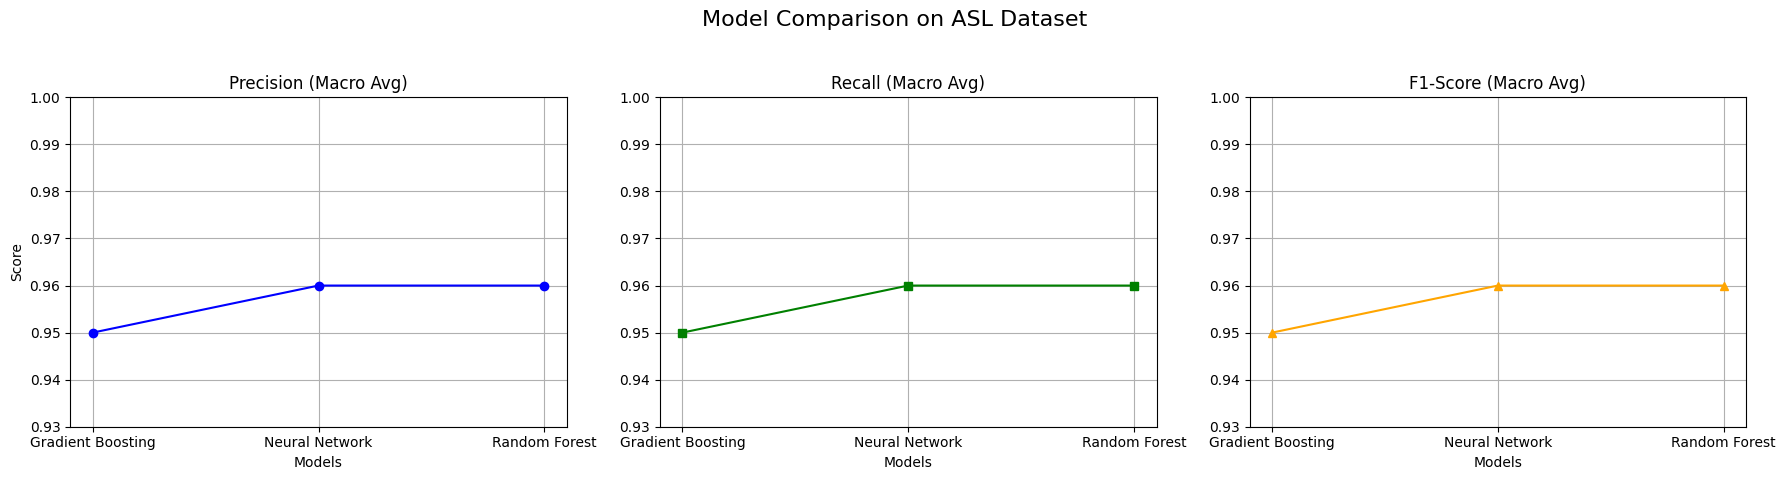

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Gradient Boosting', 'Neural Network', 'Random Forest']

# averages
precision = [0.95, 0.96, 0.96]
recall = [0.95, 0.96, 0.96]
f1_score = [0.95, 0.96, 0.96]

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Precision Plot
axs[0].plot(models, precision, marker='o', color='blue')
axs[0].set_title('Precision (Macro Avg)')
axs[0].set_ylim(0.93, 1.0)
axs[0].set_ylabel('Score')
axs[0].grid(True)

# Recall Plot
axs[1].plot(models, recall, marker='s', color='green')
axs[1].set_title('Recall (Macro Avg)')
axs[1].set_ylim(0.93, 1.0)
axs[1].grid(True)

# F1 Score Plot
axs[2].plot(models, f1_score, marker='^', color='orange')
axs[2].set_title('F1-Score (Macro Avg)')
axs[2].set_ylim(0.93, 1.0)
axs[2].grid(True)

# Shared X label
for ax in axs:
    ax.set_xlabel('Models')

plt.suptitle('Model Comparison on ASL Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
